In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


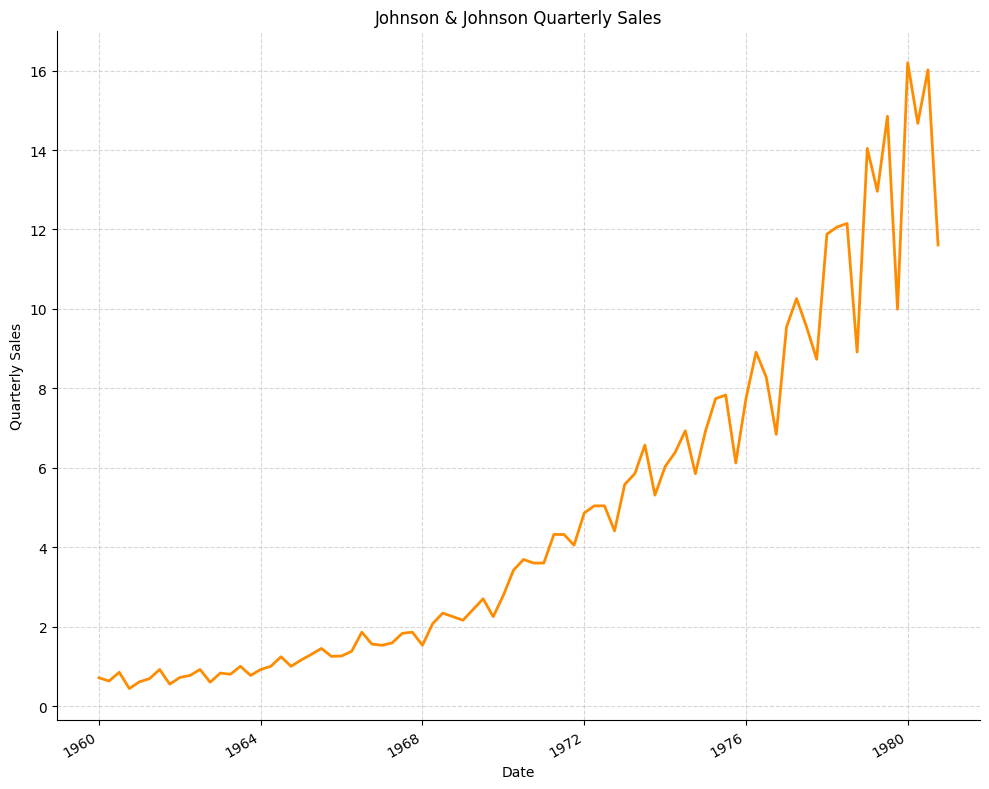

ADF Test p-value (Original Series): 1.0
ADF Test p-value (1st Difference): 0.9088542416911305
ADF Test p-value (2nd Difference): 0.006051099869603682


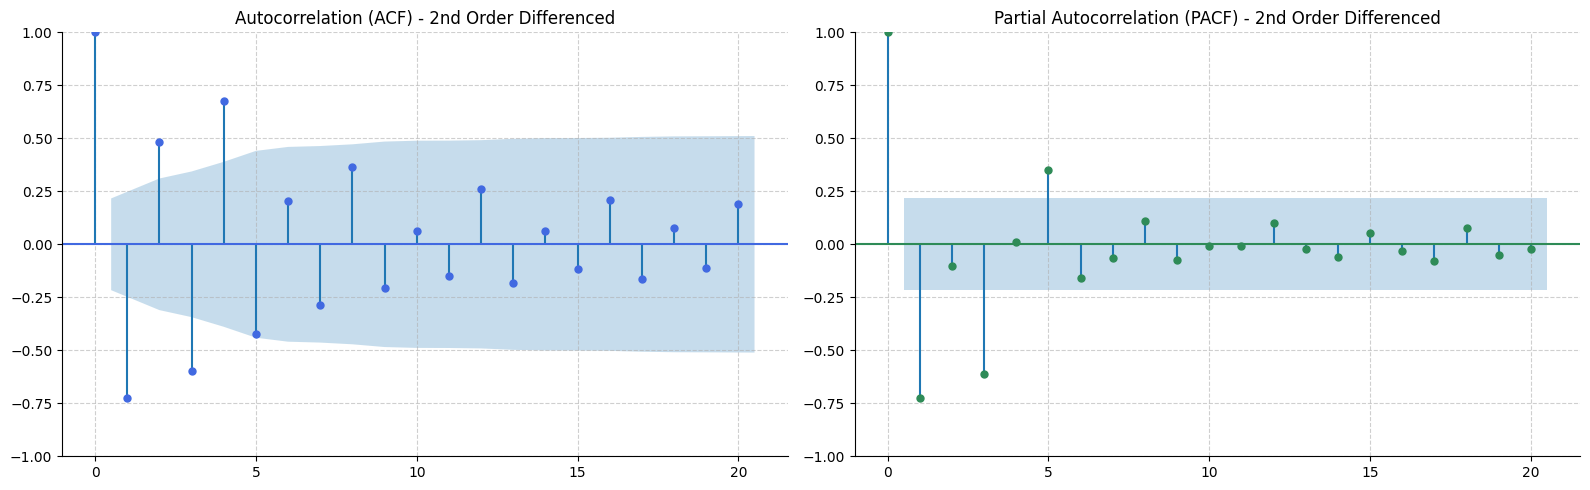

In [3]:
# ----------------------------
# Import Required Libraries
# ----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = [10, 8]

# -----------------------------------------------
# Load and Visualize Johnson & Johnson Dataset
# -----------------------------------------------
jj_sales_data = pd.read_csv('/content/drive/MyDrive/jj.csv')
jj_sales_data.columns = ['Date', 'Sales']
jj_sales_data['Date'] = pd.to_datetime(jj_sales_data['Date'])
jj_sales_data.set_index('Date', inplace=True)

# Plotting Original Time Series
jj_sales_data['Sales'].plot(kind='line', title='Johnson & Johnson Quarterly Sales',
                            color='darkorange', linewidth=2)
plt.xlabel("Date")
plt.ylabel("Quarterly Sales")
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

# -----------------------------------------------
# Stationarity Check using Augmented Dickey-Fuller Test
# -----------------------------------------------
adf_level = adfuller(jj_sales_data['Sales'].dropna())
print("ADF Test p-value (Original Series):", adf_level[1])

adf_diff1 = adfuller(jj_sales_data['Sales'].diff().dropna())
print("ADF Test p-value (1st Difference):", adf_diff1[1])

adf_diff2 = adfuller(jj_sales_data['Sales'].diff().diff().dropna())
print("ADF Test p-value (2nd Difference):", adf_diff2[1])

# Prepare Differenced Data (2nd order) for ACF & PACF
jj_diff_series = jj_sales_data['Sales'].diff().dropna().diff().dropna()

# -----------------------------------------------
# Plot ACF and PACF of Differenced Series
# -----------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(jj_diff_series, lags=20, ax=axes[0], color='royalblue')
axes[0].set_title("Autocorrelation (ACF) - 2nd Order Differenced")

plot_pacf(jj_diff_series, lags=20, ax=axes[1], color='seagreen')
axes[1].set_title("Partial Autocorrelation (PACF) - 2nd Order Differenced")

for ax in axes:
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()


Optimal ARIMA Order (p, d=2, q): (3, 2, 3)


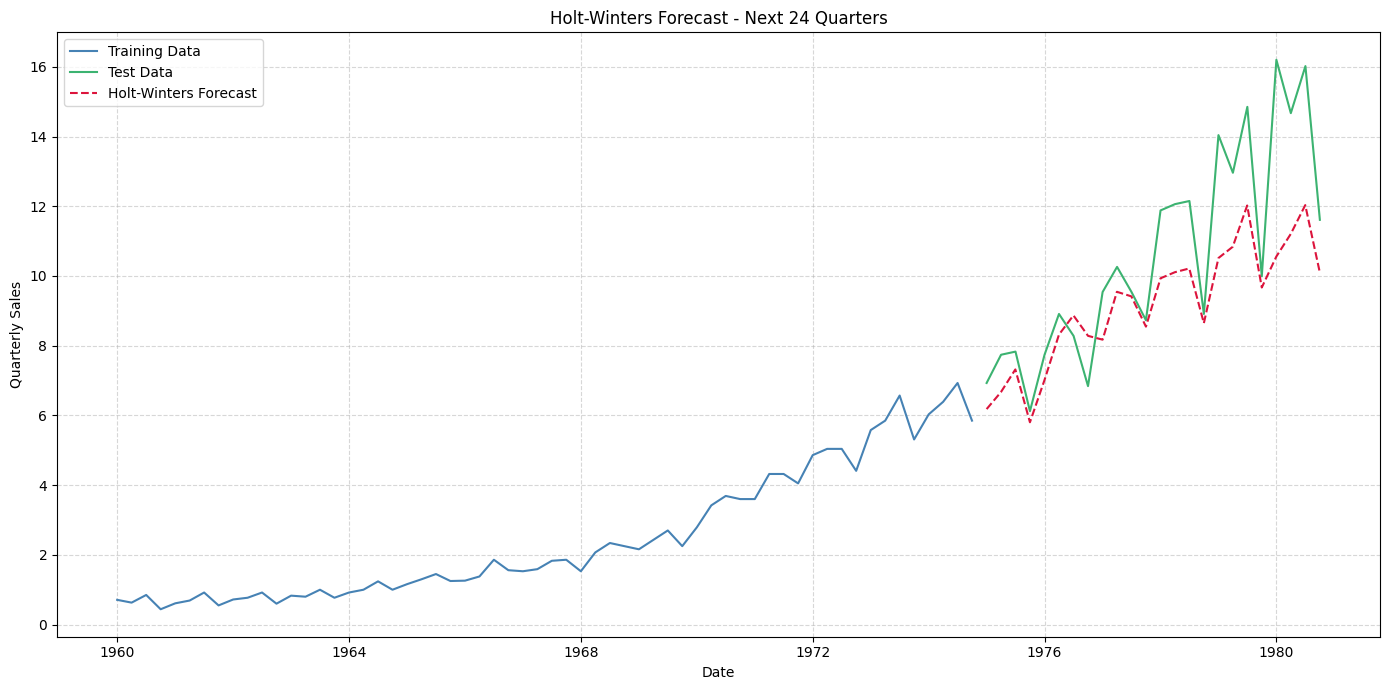

Forecast Accuracy Metrics:
MAE  : 1.5787
MSE  : 4.4277
RMSE : 2.1042


In [4]:
# -----------------------------------------------
# Grid Search for Optimal ARIMA(p, 2, q) Model
# -----------------------------------------------
best_aic = float("inf")
optimal_order = None
optimal_arima_model = None

for p in range(4):
    for q in range(4):
        try:
            arima_model = ARIMA(jj_sales_data['Sales'], order=(p, 2, q)).fit()
            if arima_model.aic < best_aic:
                best_aic = arima_model.aic
                optimal_order = (p, 2, q)
                optimal_arima_model = arima_model
        except:
            continue

print("Optimal ARIMA Order (p, d=2, q):", optimal_order)

# -----------------------------------------------
# Holt-Winters Exponential Smoothing Forecasting
# -----------------------------------------------
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Copy the dataset and apply moving averages and EWMA for visualization
jj_smoothed = jj_sales_data.copy()
jj_smoothed['SMA_6'] = jj_smoothed['Sales'].rolling(window=6).mean()
jj_smoothed['SMA_12'] = jj_smoothed['Sales'].rolling(window=12).mean()
jj_smoothed['EWMA_12'] = jj_smoothed['Sales'].ewm(span=12, adjust=False).mean()

# Split data into training and test sets
test_periods = 24
training_data = jj_smoothed[:-test_periods]
testing_data = jj_smoothed[-test_periods:]

# Fit the Holt-Winters model
hw_model = ExponentialSmoothing(
    training_data['Sales'],
    trend='add',
    seasonal='mul',
    seasonal_periods=24
).fit()

# Forecast next 24 quarters
forecast_period = 24
future_dates = pd.date_range(
    start=training_data.index[-1] + pd.DateOffset(months=3),
    periods=forecast_period,
    freq='QS'
)
hw_predictions = hw_model.forecast(forecast_period)
hw_forecast_series = pd.Series(hw_predictions.values, index=future_dates, name='HW Forecast')

# -----------------------------------------------
# Plotting Forecast vs Actual
# -----------------------------------------------
plt.figure(figsize=(14, 7))
plt.plot(training_data.index, training_data['Sales'], label='Training Data', color='steelblue')
plt.plot(testing_data.index, testing_data['Sales'], label='Test Data', color='mediumseagreen')
plt.plot(hw_forecast_series.index, hw_forecast_series, label='Holt-Winters Forecast', color='crimson', linestyle='--')
plt.title("Holt-Winters Forecast - Next 24 Quarters")
plt.xlabel("Date")
plt.ylabel("Quarterly Sales")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------------------------
# Forecast Evaluation
# -----------------------------------------------
evaluation_forecast = hw_forecast_series[:len(testing_data)]
mae = mean_absolute_error(testing_data['Sales'], evaluation_forecast)
mse = mean_squared_error(testing_data['Sales'], evaluation_forecast)
rmse = np.sqrt(mse)

print("Forecast Accuracy Metrics:")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")


**Build an RNN based model (LSTM, GRU)**

Epoch 1/50
8/8 - 4s - 488ms/step - loss: 0.1358 - val_loss: 0.5486
Epoch 2/50
8/8 - 0s - 26ms/step - loss: 0.0929 - val_loss: 0.4092
Epoch 3/50
8/8 - 0s - 32ms/step - loss: 0.0791 - val_loss: 0.2835
Epoch 4/50
8/8 - 0s - 18ms/step - loss: 0.0745 - val_loss: 0.1820
Epoch 5/50
8/8 - 0s - 18ms/step - loss: 0.0551 - val_loss: 0.1252
Epoch 6/50
8/8 - 0s - 17ms/step - loss: 0.0375 - val_loss: 0.1045
Epoch 7/50
8/8 - 0s - 18ms/step - loss: 0.0339 - val_loss: 0.1004
Epoch 8/50
8/8 - 0s - 16ms/step - loss: 0.0370 - val_loss: 0.1019
Epoch 9/50
8/8 - 0s - 22ms/step - loss: 0.0354 - val_loss: 0.0988
Epoch 10/50
8/8 - 0s - 16ms/step - loss: 0.0358 - val_loss: 0.1264
Epoch 11/50
8/8 - 0s - 15ms/step - loss: 0.0317 - val_loss: 0.0970
Epoch 12/50
8/8 - 0s - 17ms/step - loss: 0.0286 - val_loss: 0.1110
Epoch 13/50
8/8 - 0s - 15ms/step - loss: 0.0329 - val_loss: 0.1103
Epoch 14/50
8/8 - 0s - 17ms/step - loss: 0.0288 - val_loss: 0.1008
Epoch 15/50
8/8 - 0s - 17ms/step - loss: 0.0318 - val_loss: 0.0958
Epo

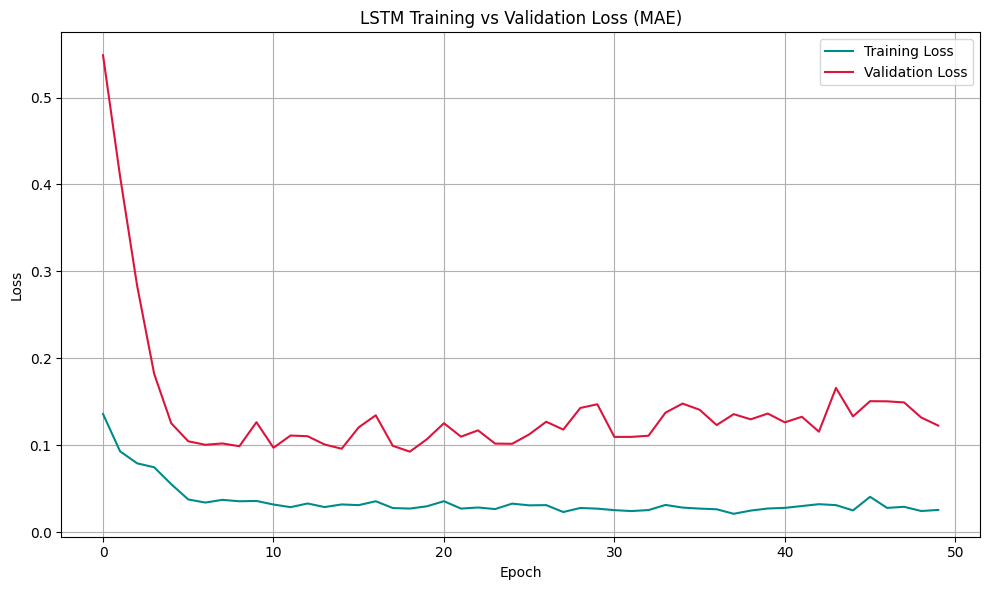

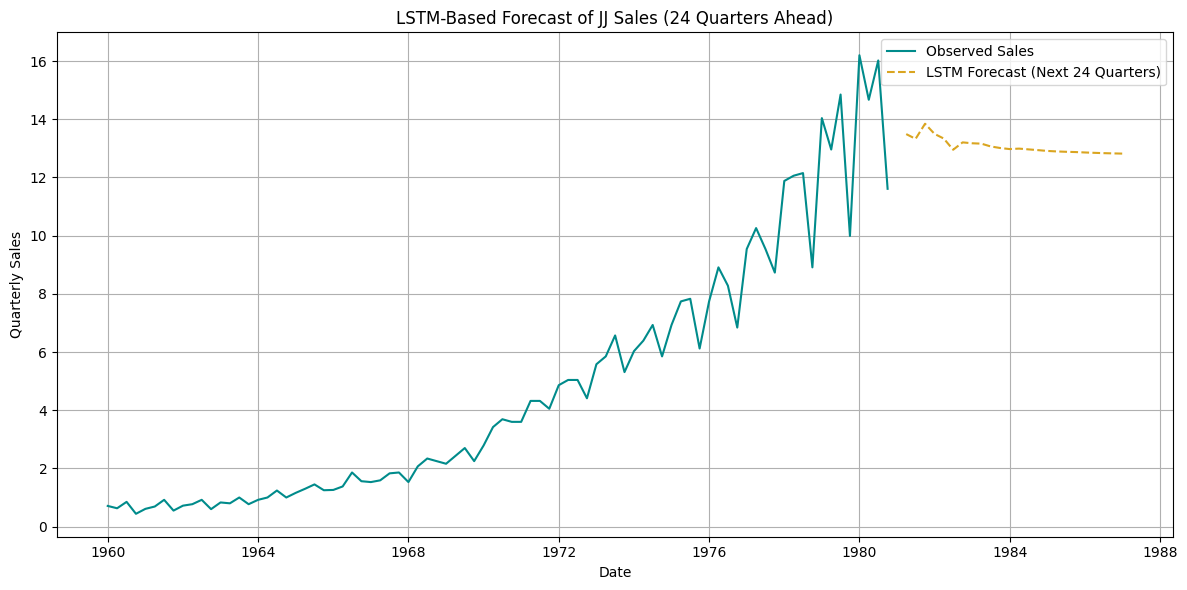

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
LSTM Model Performance on Test Set:
MAE  : 1.9310
MSE  : 4.5108
RMSE : 2.1239
R²   : 0.2291


In [5]:
from pandas import DataFrame, concat
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------------------------------
# Load and Normalize the JJ Quarterly Sales Data
# -------------------------------------------------
jj_df = pd.read_csv('/content/drive/MyDrive/jj.csv')
jj_df.columns = ['date', 'value']
jj_df['date'] = pd.to_datetime(jj_df['date'])
jj_df.set_index('date', inplace=True)

# Scale the sales values to the range [0, 1]
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(jj_df[['value']].values.astype('float32'))

# -------------------------------------------------
# Transform Time Series to Supervised Learning Format
# -------------------------------------------------
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    df = DataFrame(data)
    cols, names = [], []

    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'var{j+1}(t-{i})' for j in range(n_vars)]

    for i in range(0, n_out):
        cols.append(df.shift(-i))
        names += [f'var{j+1}(t+{i})' for j in range(n_vars)]

    agg = concat(cols, axis=1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace=True)

    return agg

# Use past 6 quarters to predict the next
supervised_df = series_to_supervised(scaled_values, n_in=6, n_out=1)

# -------------------------------------------------
# Prepare LSTM Inputs for Training and Testing
# -------------------------------------------------
X_all = supervised_df.iloc[:, :-1]
y_all = supervised_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=False)

X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

# -------------------------------------------------
# Build and Train the LSTM Forecasting Model
# -------------------------------------------------
lstm_model = Sequential()
lstm_model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(32))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mae', optimizer='adam')

history = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=8,
    validation_data=(X_test, y_test),
    verbose=2,
    shuffle=False
)

# -------------------------------------------------
# Visualize Training and Validation Loss
# -------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='darkcyan')
plt.plot(history.history['val_loss'], label='Validation Loss', color='crimson')
plt.title('LSTM Training vs Validation Loss (MAE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------------------------
# Generate Forecasts for the Next 24 Quarters
# -------------------------------------------------
last_input = scaled_values[-6:]
future_preds = []

for _ in range(24):
    seq_input = last_input.reshape((1, 6, 1))
    next_pred = lstm_model.predict(seq_input, verbose=0)[0][0]
    future_preds.append(next_pred)
    last_input = np.append(last_input[1:], [[next_pred]], axis=0)

# Rescale forecasted values back to original range
future_forecast = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# Create index for future quarters
last_known_date = jj_df.index[-1]
future_dates = pd.date_range(start=last_known_date + pd.DateOffset(months=3), periods=24, freq='Q')
future_df = pd.DataFrame(future_forecast, index=future_dates, columns=['Forecast'])

# -------------------------------------------------
# Plot Historical Data with LSTM Forecast
# -------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(jj_df.index, jj_df['value'], label='Observed Sales', color='darkcyan')
plt.plot(future_df.index, future_df['Forecast'], label='LSTM Forecast (Next 24 Quarters)', color='goldenrod', linestyle='--')
plt.title('LSTM-Based Forecast of JJ Sales (24 Quarters Ahead)')
plt.xlabel('Date')
plt.ylabel('Quarterly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------------------------
# Evaluate Model Performance on Test Set
# -------------------------------------------------
y_pred_scaled = lstm_model.predict(X_test)
y_pred_actual = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.values.reshape(-1, 1))

mae = mean_absolute_error(y_test_actual, y_pred_actual)
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred_actual)

print("LSTM Model Performance on Test Set:")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0503 - val_loss: 0.0993
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0047 - val_loss: 0.0164
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0026 - val_loss: 0.0309
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0022 - val_loss: 0.0198
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0023 - val_loss: 0.0198
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0021 - val_loss: 0.0179
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0011 - val_loss: 0.0197
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


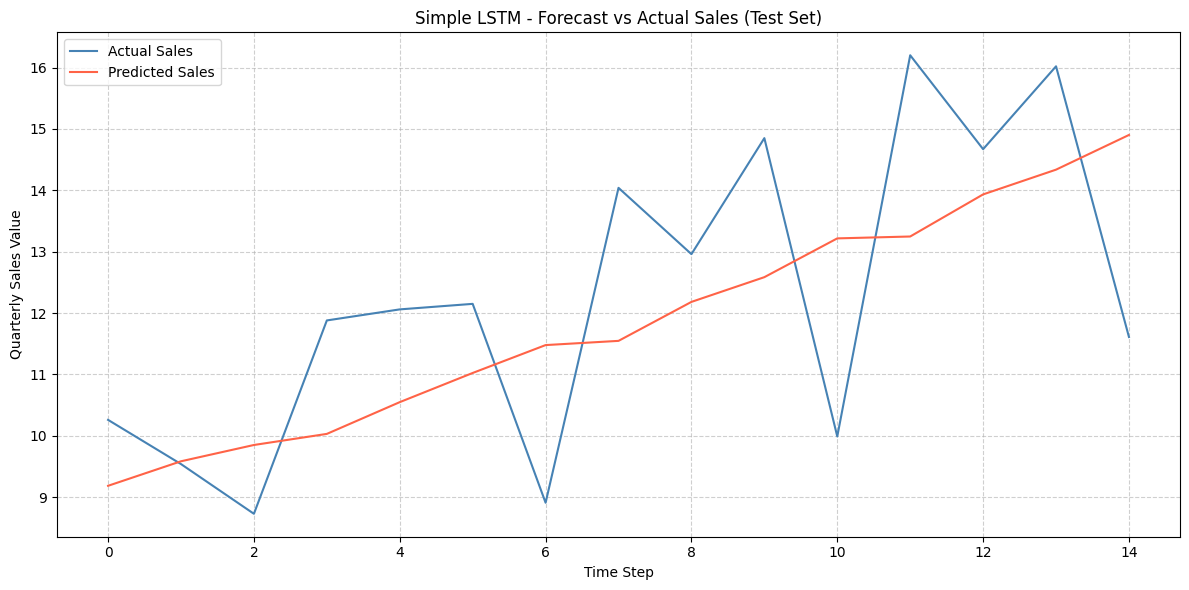

In [6]:
# -------------------------------------------------
# Normalize the JJ Sales Data for LSTM Input
# -------------------------------------------------
scaler = MinMaxScaler()
jj_df[['value']] = scaler.fit_transform(jj_df[['value']])

# -------------------------------------------------
# Generate Input Sequences for Supervised Learning
# -------------------------------------------------
def create_sequences(data_series, seq_length):
    X, y = [], []
    for i in range(len(data_series) - seq_length):
        X.append(data_series[i:i+seq_length])
        y.append(data_series[i+seq_length])
    return np.array(X), np.array(y)

sequence_len = 12  # Use past 12 quarters
X, y = create_sequences(jj_df['value'].values, sequence_len)
X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape for LSTM [samples, time steps, features]

# -------------------------------------------------
# Split Data into Training and Testing Sets
# -------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# -------------------------------------------------
# Define and Train a Simple LSTM Model
# -------------------------------------------------
lstm_model_simple = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])

lstm_model_simple.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lstm_model_simple.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=8,
    callbacks=[early_stopping],
    verbose=1
)

# -------------------------------------------------
# Plot Model Predictions Against Actual Sales
# -------------------------------------------------
def plot_predictions(model, X_test, y_test, model_name="Model"):
    predictions = model.predict(X_test)
    plt.figure(figsize=(12, 6))
    plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual Sales', color='steelblue')
    plt.plot(scaler.inverse_transform(predictions), label='Predicted Sales', color='tomato')
    plt.title(f"{model_name} - Forecast vs Actual Sales (Test Set)")
    plt.xlabel("Time Step")
    plt.ylabel("Quarterly Sales Value")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# -------------------------------------------------
# Visualize Forecasting Results
# -------------------------------------------------
plot_predictions(lstm_model_simple, X_test, y_test, "Simple LSTM")


In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# -----------------------------------------------
# Generate Predictions on the Test Set
# -----------------------------------------------
lstm_predictions_scaled = lstm_model_simple.predict(X_test)

# Inverse transform predictions and actual values to original scale
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_actual = scaler.inverse_transform(lstm_predictions_scaled).flatten()

# -----------------------------------------------
# Compute Key Evaluation Metrics
# -----------------------------------------------
mae_lstm = mean_absolute_error(y_test_actual, y_pred_actual)
rmse_lstm = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mape_lstm = mean_absolute_percentage_error(y_test_actual, y_pred_actual)

# -----------------------------------------------
# Display LSTM Model Performance
# -----------------------------------------------
print("📊 LSTM Forecast Evaluation on Test Set:")
print(f"Mean Absolute Error (MAE) : {mae_lstm:.4f}")
print(f"Root Mean Squared Error (RMSE) : {rmse_lstm:.4f}")
print(f"Mean Absolute Percentage Error (MAPE) : {mape_lstm:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
📊 LSTM Forecast Evaluation on Test Set:
Mean Absolute Error (MAE) : 1.7814
Root Mean Squared Error (RMSE) : 2.0210
Mean Absolute Percentage Error (MAPE) : 0.1489


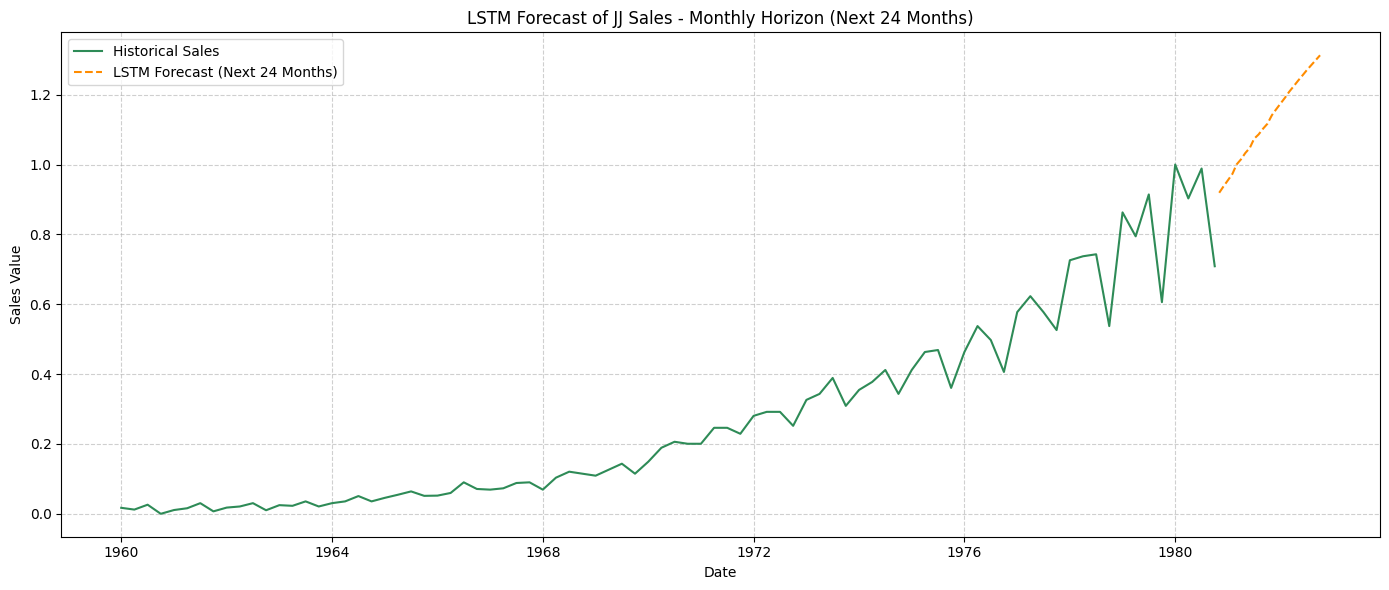

In [8]:
# -------------------------------------------------
# Define LSTM-Based Future Forecasting Function
# -------------------------------------------------
def forecast_future(model, scaled_data, scaler, n_future=24, seq_len=12):
    """
    Generate future forecasts using the trained LSTM model.

    Parameters:
    - model: Trained LSTM model
    - scaled_data: Scaled historical time series
    - scaler: Fitted MinMaxScaler for inverse transformation
    - n_future: Number of future time steps to predict
    - seq_len: Input sequence length for the model

    Returns:
    - Inverse-transformed forecasted values (numpy array)
    """
    last_seq = scaled_data[-seq_len:].reshape(1, seq_len, 1)
    forecast = []

    for _ in range(n_future):
        next_pred = model.predict(last_seq, verbose=0)[0][0]
        forecast.append(next_pred)
        last_seq = np.append(last_seq[:, 1:, :], [[[next_pred]]], axis=1)

    return scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# -------------------------------------------------
# Prepare Scaled Input Series for Forecasting
# -------------------------------------------------
scaler = MinMaxScaler()
scaled_series = scaler.fit_transform(jj_df['value'].values.reshape(-1, 1))

# Forecast Next 24 Months (Monthly Interval)
future_forecast = forecast_future(
    model=lstm_model_simple,
    scaled_data=scaled_series,
    scaler=scaler,
    n_future=24,
    seq_len=12
)

# Create corresponding future date range
forecast_start = jj_df.index[-1] + pd.DateOffset(months=1)
future_dates = pd.date_range(start=forecast_start, periods=24, freq='MS')

# -------------------------------------------------
# Plot Forecasted Sales vs Historical Sales
# -------------------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(jj_df.index, scaler.inverse_transform(scaled_series), label='Historical Sales', color='seagreen')
plt.plot(future_dates, future_forecast, label='LSTM Forecast (Next 24 Months)', color='darkorange', linestyle='--')
plt.title('LSTM Forecast of JJ Sales - Monthly Horizon (Next 24 Months)')
plt.xlabel('Date')
plt.ylabel('Sales Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
